<a href="https://colab.research.google.com/github/Camouflage10/driven-quake/blob/main/quake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#get a different feature selection
#change to f1 score
#hyper param tuning
#pca- 95 .65
#corr- .07 .58
#corr- .04 .54 best
#svm full training .57 -overfit
#.03 .546
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from xgboost import XGBClassifier

In [3]:
submission=pd.read_csv('submission_format.csv')
test=pd.read_csv('test_values.csv')
trainy=pd.read_csv('train_labels.csv')
trainx=pd.read_csv('train_values.csv')
trainx

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,...,0,0,0,0,0,0,0,0,0,0
260597,669485,17,715,2060,2,0,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
260598,602512,17,51,8163,3,55,6,7,t,r,...,0,0,0,0,0,0,0,0,0,0
260599,151409,26,39,1851,2,10,14,6,t,r,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#explore preprocessed data
train=trainx.merge(trainy,on=['building_id'])
train['land_surface_condition']=pd.factorize(train['land_surface_condition'])[0]
train['foundation_type']=pd.factorize(train['foundation_type'])[0]
train['roof_type']=pd.factorize(train['roof_type'])[0]
train['ground_floor_type']=pd.factorize(train['ground_floor_type'])[0]
train['other_floor_type']=pd.factorize(train['other_floor_type'])[0]
train['position']=pd.factorize(train['position'])[0]
train['plan_configuration']=pd.factorize(train['plan_configuration'])[0]
train['legal_ownership_status']=pd.factorize(train['legal_ownership_status'])[0]



In [5]:
#test
test['land_surface_condition']=pd.factorize(test['land_surface_condition'])[0]
test['foundation_type']=pd.factorize(test['foundation_type'])[0]
test['roof_type']=pd.factorize(test['roof_type'])[0]
test['ground_floor_type']=pd.factorize(test['ground_floor_type'])[0]
test['other_floor_type']=pd.factorize(test['other_floor_type'])[0]
test['position']=pd.factorize(test['position'])[0]
test['plan_configuration']=pd.factorize(test['plan_configuration'])[0]
test['legal_ownership_status']=pd.factorize(test['legal_ownership_status'])[0]

In [6]:
#preprocess- include submission
#bin age 
y=train[['damage_grade']]
x=train.drop(columns=['building_id','damage_grade'])
xtest=test.drop(columns=['building_id'])
x

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,6,487,12198,2,30,6,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,900,2812,2,10,8,7,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21,363,8973,2,10,5,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22,418,10694,2,10,6,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11,131,1488,3,30,8,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,25,1335,1621,1,55,6,3,2,0,0,...,0,0,0,0,0,0,0,0,0,0
260597,17,715,2060,2,0,6,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260598,17,51,8163,3,55,6,7,0,0,1,...,0,0,0,0,0,0,0,0,0,0
260599,26,39,1851,2,10,14,6,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#tremove features with a corrilation of less than abs(mincorr)
minCorr=.04
corrMatrix = train.corr()
lastCol=corrMatrix['damage_grade']
print(lastCol)
features=list(lastCol.loc[abs(lastCol) > minCorr].index)
features.remove('damage_grade')
print(len(features))
print(features)
xtest=test[features]
x=train[features]
corrMatrix = train.corr()
for col in x.columns:
  print(col+":  "+str(train[col].isna().sum()))

building_id                               0.001063
geo_level_1_id                           -0.072347
geo_level_2_id                            0.043161
geo_level_3_id                            0.007932
count_floors_pre_eq                       0.122308
age                                       0.029273
area_percentage                          -0.125221
height_percentage                         0.048130
land_surface_condition                    0.012218
foundation_type                          -0.293295
roof_type                                -0.173890
ground_floor_type                        -0.285687
other_floor_type                         -0.247667
position                                 -0.055138
plan_configuration                       -0.027426
has_superstructure_adobe_mud              0.055314
has_superstructure_mud_mortar_stone       0.291325
has_superstructure_stone_flag             0.066039
has_superstructure_cement_mortar_stone   -0.060295
has_superstructure_mud_mortar_b

In [ ]:
%%time
#6min per iteration
#model
#add parameters\/
#add bool to make catagoricals avilable and change data to catagoricals
#importance_type
#reg_lambda
#skopt.BayesSearchCV
#3d graphing hyperparam f1 performance 
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from xgboost import XGBClassifier
hyperbag={'n_estimators': Integer(200, 300),'learning_rate': Real(.5,.85),'grow_policy': Categorical(['depthwise', 'lossguide']) , 'booster':Categorical(['gbtree']), 'max_depth':Integer(3,6), 'reg_alpha': Real(0.0,1.0)}#-add verbosity
boost = XGBClassifier()
boost_grid=BayesSearchCV(boost,hyperbag, n_iter=6 ,cv=2, scoring='f1_micro',return_train_score=True, verbose=10)
boost_grid.fit(x,y)
boost_pred=boost_grid.predict(x)
boost_results=pd.DataFrame(boost_grid.cv_results_)
print(boost_grid.best_params_)
print(boost_grid.best_score_)
boost_results

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START booster=gbtree, grow_policy=lossguide, learning_rate=0.7428439447892123, max_depth=4, n_estimators=245, reg_alpha=0.840614124066262


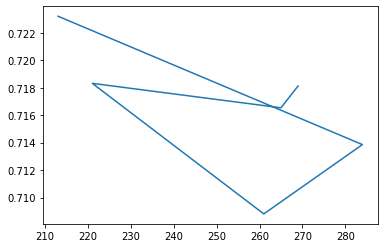

In [9]:
#graph hyper param results x-param y-rank
plt.plot(boost_results['param_n_estimators'],boost_results['mean_test_score'])

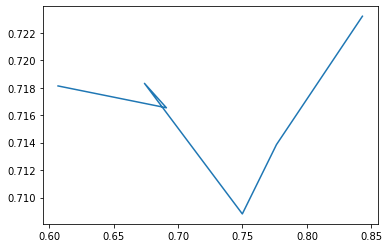

In [10]:
plt.plot(boost_results['param_learning_rate'],boost_results['mean_test_score'])

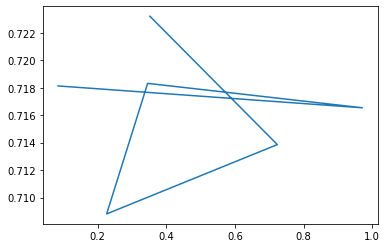

In [11]:
plt.plot(boost_results['param_reg_alpha'],boost_results['mean_test_score'])

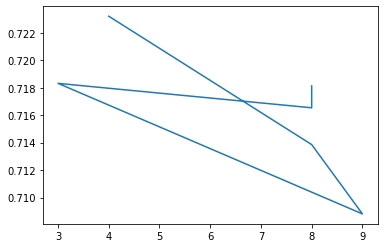

In [12]:
plt.plot(boost_results['param_max_depth'],boost_results['mean_test_score'])

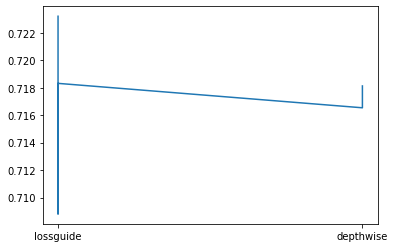

In [13]:
plt.plot(boost_results['param_grow_policy'],boost_results['mean_test_score'])

In [ ]:
train_x, test_x, train_y, test_y=train_test_split(x ,y , train_size=.2,stratify=y)

In [15]:
%%time
#select model
# booster=gbtree, grow_policy=lossguide, learning_rate=0.8430852857596043, max_depth=4, n_estimators=213, reg_alpha=0.3521851245194177- .724
#booster=gbtree, grow_policy=lossguide, learning_rate=0.6147687924138241, max_depth=6, n_estimators=253, reg_alpha=0.9346851043944999 -.726
model=XGBClassifier( booster='gbtree', grow_policy='lossguide', learning_rate=0.8430852857596043, max_depth=4, n_estimators=213, reg_alpha=0.3521851245194177)
model.fit(x,y)

CPU times: user 2min 40s, sys: 386 ms, total: 2min 40s
Wall time: 2min 43s


XGBClassifier(grow_policy='lossguide', learning_rate=0.8430852857596043,
              max_depth=4, n_estimators=213, objective='multi:softprob',
              reg_alpha=0.3521851245194177)

In [16]:
#submission
pred=model.predict(xtest)
submission['damage_grade']=pred

submission.to_csv('submission.csv', index=False)